file already exist
file already exist
(100, 100, 1)
(100, 100, 1)
(100, 100, 1)
(100, 100, 1)
(100, 100, 1)
(100, 100, 1)
(100, 100, 1)
(100, 100, 1)
(100, 100, 1)
(100, 100, 1)
(100, 100, 1)
(100, 100, 1)


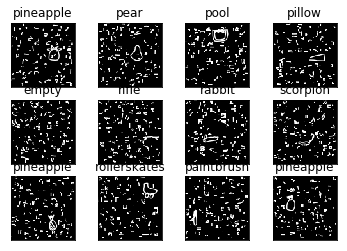

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import os
from random import shuffle
from tqdm import tqdm
import csv
import sys
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')
import keras
sys.stderr = stderr
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.utils import plot_model
from keras.models import load_model

image_colmn = 100
image_row  = 100
read_train_filename = './all/train_images.npy'

train_label_filename = './all/train_labels.csv'
train_data_filename = './train_data.npy'

read_test_filename = './all/test_images.npy'

test_data_filename = './test_data.npy'
class_name_list =["sink","pear","moustache","nose","skateboard","penguin","peanut","skull","panda","paintbrush","nail","apple","rifle","mug","sailboat","pineapple","spoon","rabbit","shovel","rollerskates","screwdriver","scorpion","rhinoceros","pool","octagon","pillow","parrot","squiggle","mouth","empty","pencil"]
num_classes = 31

def create_train_data():
    class_label_name=[]
    with open (train_label_filename,'r',) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            
            class_label_name.append(row)
    del class_label_name[0]
    class_id_list = []
    for i in range(len(class_name_list)):
        class_id_list.append(i)
        
    hashmap = dict(zip(class_name_list,class_id_list))
    class_label_vector=[]

    for r in tqdm(class_label_name):
        word = r[1]
        if word in hashmap:
            class_label_vector.append(hashmap[word])
    images = np.load(read_train_filename,encoding='latin1')
    train_data=[]
    for i in tqdm(range(len(images))):
            train_data.append([np.array((images[i][1]).reshape(1,10000)),np.array(class_label_vector[i])])
    np.save('train_data.npy',train_data)
    return train_data

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape) == 2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))

    return map_coordinates(image, indices, order=1).reshape(shape)

    
        
def norm_input(x):
    return (x - mean_px) / std_px

if __name__ == '__main__':
    if (os.path.isfile(train_data_filename)==False):
        train_data = create_train_data()
                
    else:
        print("file already exist")
        train_data = np.load(train_data_filename,encoding='latin1')

        
    if (os.path.isfile(test_data_filename)==False):
        images = np.load(read_test_filename,encoding='latin1')
        test_data=[]
        for i in tqdm(range(len(images))):
            test_data.append(np.array((images[i][1])))
        np.save('test_data.npy',test_data)
    
    else:
        print("file already exist")
        test_data = np.load(test_data_filename,encoding='latin1')
    aug_epochs = 1
    test_size = 0.1
    #seed 
    random_seed = 1
    learning_rate=0.001
    version =1
    batch_size=64
    epochs=20
    test_size = 0.1
    train = train_data
    y=[]
    y_raw = [i[1] for i in train]

    y=np.asarray(y_raw,dtype=float)

    y = y.reshape((-1,1))

    x = np.array([i[0] for i in train])

    x = x.reshape((-1,image_colmn,image_row))
    input_shape = (image_colmn, image_row, 1)
    test_x = np.array([i[0] for i in test_data])
    test_x =test_x.reshape((-1,image_colmn,image_row,1))


    distort_1 = np.zeros(shape=x.shape, dtype='float32')
    distort_2 = np.zeros(shape=x.shape, dtype='float32')
    distort_3 = np.zeros(shape=x.shape, dtype='float32')

    for i in range(x.shape[0]):
        distort_1[i] = elastic_transform(image=x[i], alpha=36, sigma=10)
        distort_2[i] = elastic_transform(image=x[i], alpha=36, sigma=8)
        distort_3[i] = elastic_transform(image=x[i], alpha=36, sigma=6)
    x = np.concatenate((x, distort_1, distort_2, distort_3), axis=0)
    y = np.concatenate((y, y, y, y), axis=0)

    x = x.reshape((-1,image_colmn,image_row,1))
    y = y.reshape((y.shape[0],))
    x = x.astype('float32')
    test_x = test_x.astype('float32')
    x /= 255
    test_x /= 255
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=111)
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    mean_px = x_train.mean().astype(np.float32)
    std_px = x_train.std().astype(np.float32)

    
    model = Sequential([
        Lambda(norm_input, input_shape=input_shape),

        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # BatchNormalization(),
        # MaxPooling2D(pool_size=(2, 2)),
        # Dropout(0.25),

        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        # Dense(512, activation='relu'),
        # BatchNormalization(),
        # Dropout(0.5),
        # Dense(512, activation='relu'),
        # BatchNormalization(),
        # Dropout(0.5),
        Dense(31, activation='softmax')
    ])
    model.load_weights('model_1.h5')

    predict_result = model.predict_classes(test_x, batch_size=batch_size, verbose=0)
    fig = plt.figure()

    for num ,data in enumerate(test_x[:12]):
    #img_class = data[1]
    #img_data = data[0].reshape(100,100)
        print(data.shape)
        img_data = data.reshape(100,100)
        plot= fig.add_subplot(3,4,num+1)
        orig = img_data
        data = img_data.reshape(image_colmn,image_row,1)
        str_label=class_name_list[predict_result[num]]
        plot.imshow(orig,cmap='gray')
        plt.title(str_label)
        plot.axes.get_xaxis().set_visible(False)
        plot.axes.get_yaxis().set_visible(False)
    plt.show()

In [4]:

with open ('submission.csv','w',) as csvfile: 
    csvfile.write('Id')
    csvfile.write(",")
    csvfile.write('Category')
    csvfile.write('\n')
    for i in range(len(predict_result)):
            csvfile.write('%d'%i)
            csvfile.write(",")
            csvfile.write(class_name_list[predict_result[i]])
            csvfile.write('\n')